In [2]:
!wget -O dataset.zip "https://physionet.org/content/noneeg/get-zip/1.0.0/"


--2025-07-30 15:15:21--  https://physionet.org/content/noneeg/get-zip/1.0.0/
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3925168 (3.7M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]   3.74M   512KB/s    in 7.5s    

2025-07-30 15:15:29 (513 KB/s) - ‘dataset.zip’ saved [3925168/3925168]



In [3]:
!unzip /content/dataset.zip -d dataset

Archive:  /content/dataset.zip
 extracting: dataset=/non-eeg-dataset-for-assessment-of-neurological-status-1.0.0/Subject6_AccTempEDA.dat  
 extracting: dataset=/non-eeg-dataset-for-assessment-of-neurological-status-1.0.0/Subject19_AccTempEDA.atr  
 extracting: dataset=/non-eeg-dataset-for-assessment-of-neurological-status-1.0.0/Subject17_SpO2HR.dat  
 extracting: dataset=/non-eeg-dataset-for-assessment-of-neurological-status-1.0.0/Subject12_SpO2HR.dat  
 extracting: dataset=/non-eeg-dataset-for-assessment-of-neurological-status-1.0.0/Subject13_SpO2HR.dat  
 extracting: dataset=/non-eeg-dataset-for-assessment-of-neurological-status-1.0.0/Subject3_SpO2HR.hea  
 extracting: dataset=/non-eeg-dataset-for-assessment-of-neurological-status-1.0.0/Subject6_AccTempEDA.hea  
 extracting: dataset=/non-eeg-dataset-for-assessment-of-neurological-status-1.0.0/Subject1_SpO2HR.dat  
 extracting: dataset=/non-eeg-dataset-for-assessment-of-neurological-status-1.0.0/Subject14_AccTempEDA.atr  
 extracting:

In [6]:
import os
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from scipy.signal import savgol_filter





Read WFDB signal files for each subject.

Apply Savitzky-Golay filter to smooth noisy signals.

Label the first half of samples as 'calm' and the second half as 'stress'.

Extract statistical features like mean, min, max

Prepare features and labels for machine learning models.

In [61]:
import os
import wfdb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.signal import savgol_filter

def extract_features(df, window=1000):
    features, labels = [], []
    for i in range(0, len(df) - window, window):
        segment = df.iloc[i:i + window]
        feat = segment.drop(columns=['label', 'subject_id']).agg(['mean', 'std', 'min', 'max']).values.flatten()
        features.append(feat)
        labels.append(segment['label'].mode()[0])
    return features, labels

def load_all_subjects(data_path, num_subjects=20):
    X_all, y_all = [], []
    all_dfs = []

    for subject_id in range(1, num_subjects + 1):
        sid = f"Subject{subject_id}"
        try:
            rec_eda = wfdb.rdrecord(os.path.join(data_path, f"{sid}_AccTempEDA"))
            rec_hr = wfdb.rdrecord(os.path.join(data_path, f"{sid}_SpO2HR"))

            df_eda = pd.DataFrame(rec_eda.p_signal, columns=rec_eda.sig_name)
            df_hr = pd.DataFrame(rec_hr.p_signal, columns=rec_hr.sig_name)

            df = pd.concat([df_eda, df_hr], axis=1)

            for col in ['EDA', 'SpO2', 'HR', 'TEMP', 'ax', 'ay', 'az']:
                if col in df.columns:
                    df[col] = savgol_filter(df[col], window_length=51, polyorder=3)

            df['label'] = ['calm' if i < len(df) // 2 else 'stress' for i in range(len(df))]
            df['subject_id'] = subject_id

            feats, labs = extract_features(df)
            X_all.extend(feats)
            y_all.extend(labs)

            all_dfs.append(df)

        except Exception as e:
            print(f"[Error] {sid}: {e}")

    X_df = pd.DataFrame(X_all)
    X_df['label'] = y_all
    y_series = pd.Series(y_all)
    combined_df = pd.concat(all_dfs, ignore_index=True)
    return X_df, y_series, combined_df

data_path = "/content/dataset=/non-eeg-dataset-for-assessment-of-neurological-status-1.0.0"
X_df, y_series, all_data_df = load_all_subjects(data_path)

print(X_df.head())


          0         1         2          3         4          5          6  \
0  0.446106 -0.964941 -0.096645  30.798137  0.084657  96.176489  84.742234   
1  0.168963 -1.046222 -0.110009  31.666621  0.087063  95.732573  80.948363   
2  0.349908 -0.680132 -0.612089  32.197376  0.091568  95.112159  77.518786   
3  0.418686 -0.430457 -0.946235  32.573159  0.104032        NaN        NaN   
4  0.718978 -0.456044 -0.778823  32.578159  0.176230        NaN        NaN   

          7         8         9  ...         19         20        21  \
0  0.290516  0.077170  0.010564  ...  94.807892  66.000336  0.762895   
1  0.028319  0.001598  0.003504  ...  94.272867  72.000366  0.246935   
2  0.111533  0.302774  0.416216  ...  93.975904  71.000671  0.587356   
3  0.041156  0.091890  0.122424  ...        NaN        NaN  0.548201   
4  0.126579  0.040525  0.088597  ...        NaN        NaN  0.868399   

         22        23         24        25         26          27  label  
0 -0.867499 -0.051180  

          0         1         2          3         4          5          6  \
0  0.446106 -0.964941 -0.096645  30.798137  0.084657  96.176489  84.742234   
1  0.168963 -1.046222 -0.110009  31.666621  0.087063  95.732573  80.948363   
2  0.349908 -0.680132 -0.612089  32.197376  0.091568  95.112159  77.518786   
3  0.418686 -0.430457 -0.946235  32.573159  0.104032        NaN        NaN   
4  0.718978 -0.456044 -0.778823  32.578159  0.176230        NaN        NaN   

          7         8         9  ...         19         20        21  \
0  0.290516  0.077170  0.010564  ...  94.807892  66.000336  0.762895   
1  0.028319  0.001598  0.003504  ...  94.272867  72.000366  0.246935   
2  0.111533  0.302774  0.416216  ...  93.975904  71.000671  0.587356   
3  0.041156  0.091890  0.122424  ...        NaN        NaN  0.548201   
4  0.126579  0.040525  0.088597  ...        NaN        NaN  0.868399   

         22        23         24        25         26          27  label  
0 -0.867499 -0.051180  

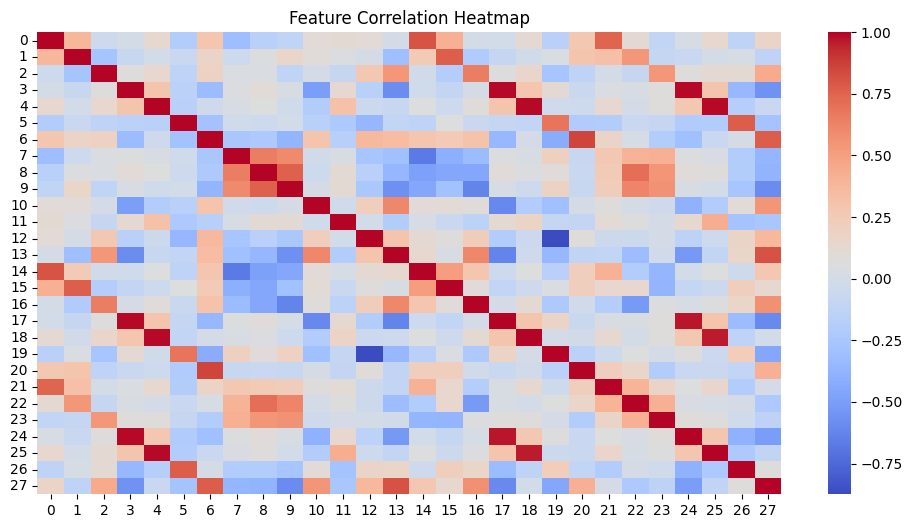

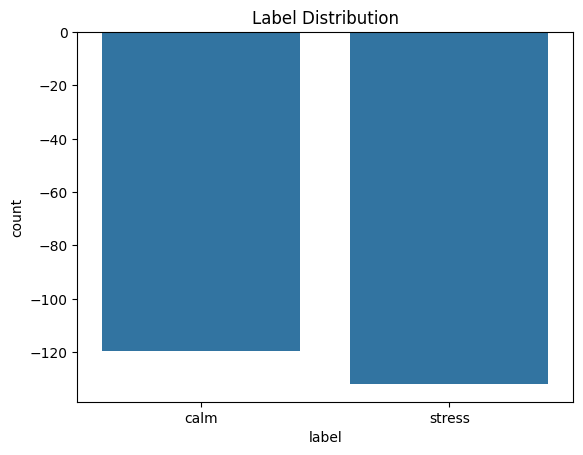

In [62]:
X_df['label'] = y_series

print(X_df.head())
print(X_df['label'].value_counts())

plt.figure(figsize=(12, 6))
sns.heatmap(X_df.drop('label', axis=1).corr(), cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

sns.countplot(x='label', data=X_df)
plt.title("Label Distribution")
plt.show()

In [63]:
print(all_data_df.head())
print(all_data_df.columns.tolist())


         ax        ay        az       temp       EDA       SpO2         hr  \
0  0.762895 -0.867499 -0.103521  30.100043  0.080951  96.534053  89.000763   
1  0.761088 -0.868641 -0.103790  30.100043  0.081098  96.530695  88.000137   
2  0.759476 -0.869667 -0.104021  30.100043  0.081236  96.528257  87.000443   
3  0.758048 -0.870582 -0.104216  30.100043  0.081367  96.526669  87.000443   
4  0.756796 -0.871391 -0.104375  30.100043  0.081488  96.525864  87.000443   

  label  subject_id  
0  calm           1  
1  calm           1  
2  calm           1  
3  calm           1  
4  calm           1  
['ax', 'ay', 'az', 'temp', 'EDA', 'SpO2', 'hr', 'label', 'subject_id']


Visualizing data

In [64]:
subject_id = 1
subject_df = all_data_df[all_data_df['subject_id'] == subject_id]


In [65]:
import matplotlib.pyplot as plt
import seaborn as sns


In [66]:
calm_sub = subject_df[subject_df['label'] == 'calm']
stress_sub = subject_df[subject_df['label'] == 'stress']


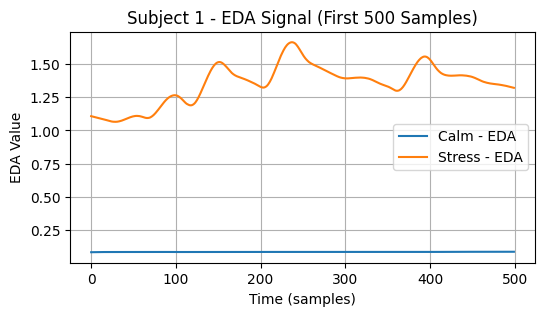

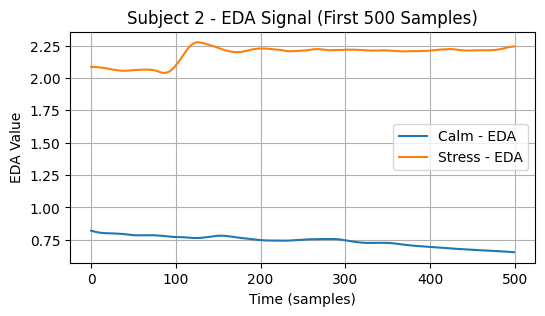

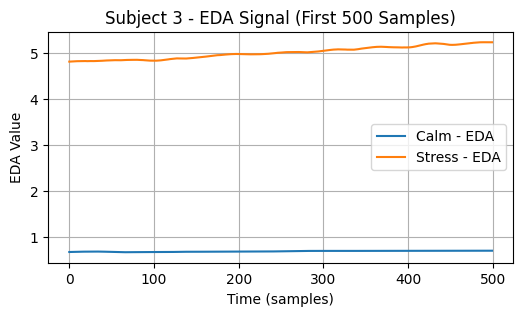

In [82]:
import matplotlib.pyplot as plt

for subject_id in range(1, 4):
    subject_data = all_data_df[all_data_df['subject_id'] == subject_id]

    calm_sub = subject_data[subject_data['label'] == 'calm']
    stress_sub = subject_data[subject_data['label'] == 'stress']

    plt.figure(figsize=(6, 3))
    plt.plot(calm_sub['EDA'][:500].reset_index(drop=True), label='Calm - EDA')
    plt.plot(stress_sub['EDA'][:500].reset_index(drop=True), label='Stress - EDA')
    plt.title(f"Subject {subject_id} - EDA Signal (First 500 Samples)")
    plt.xlabel("Time (samples)")
    plt.ylabel("EDA Value")
    plt.legend()
    plt.grid(True)
    plt.show()


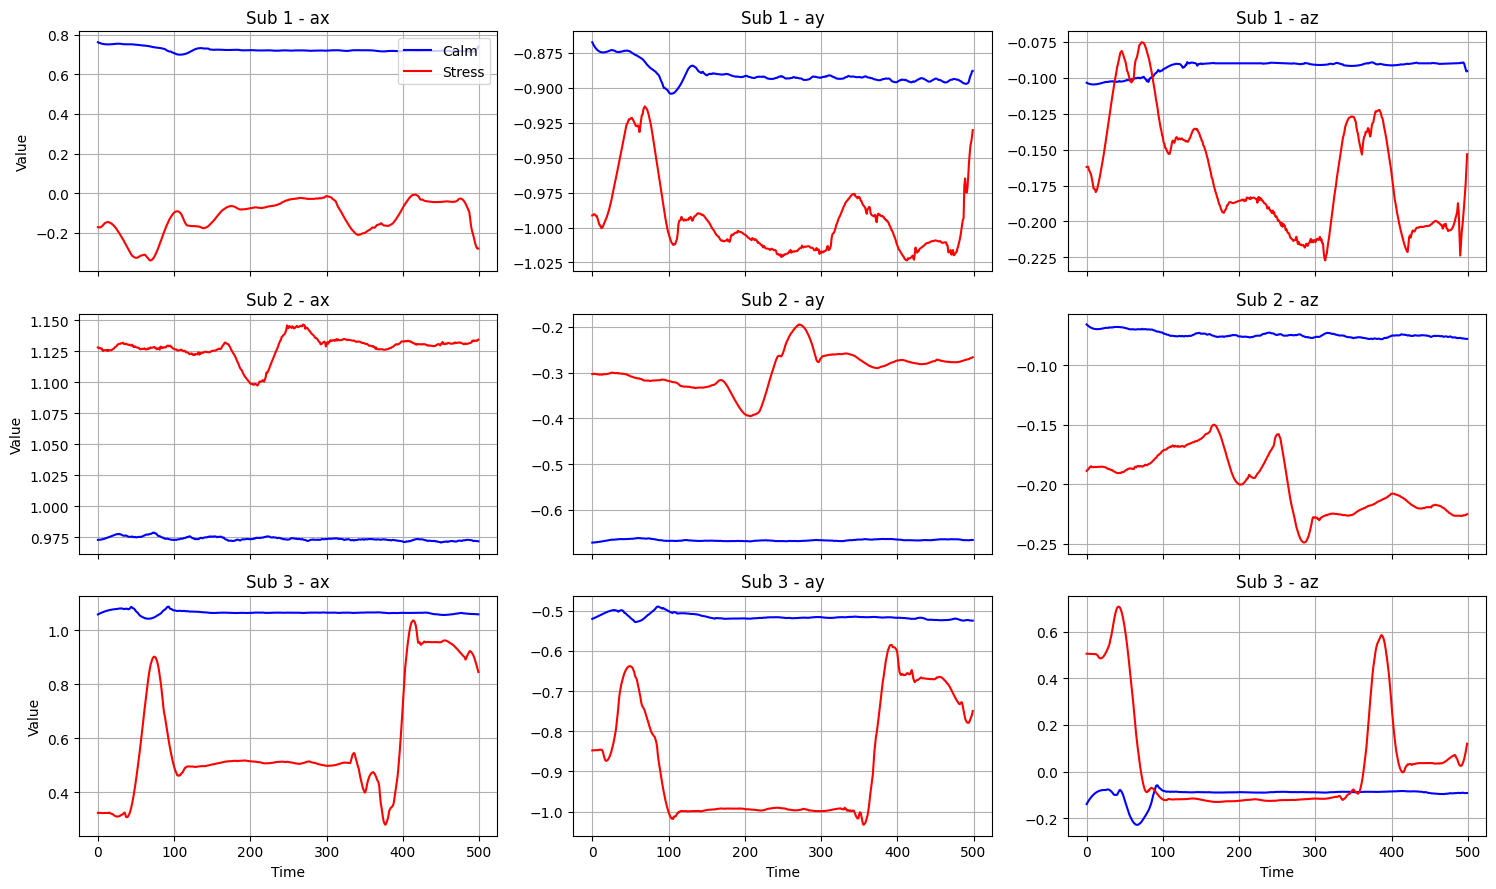

In [72]:
import matplotlib.pyplot as plt
import numpy as np

subject_ids = all_data_df['subject_id'].unique()[0:3]
axes = ['ax', 'ay', 'az']

fig, axs = plt.subplots(len(subject_ids), len(axes), figsize=(15, len(subject_ids)*3), sharex=True)

for i, subject_id in enumerate(subject_ids):
    subject_df = all_data_df[all_data_df['subject_id'] == subject_id]
    calm_sub = subject_df[subject_df['label'] == 'calm']
    stress_sub = subject_df[subject_df['label'] == 'stress']

    for j, axis in enumerate(axes):
        ax = axs[i, j] if len(subject_ids) > 1 else axs[j]
        ax.plot(calm_sub[axis][:500].reset_index(drop=True), label='Calm', color='blue')
        ax.plot(stress_sub[axis][:500].reset_index(drop=True), label='Stress', color='red')
        ax.set_title(f"Sub {subject_id} - {axis}")
        ax.grid(True)

        if i == len(subject_ids)-1:
            ax.set_xlabel("Time")
        if j == 0:
            ax.set_ylabel("Value")

# Add legend to the first subplot only
axs[0, 0].legend(loc='upper right')
plt.tight_layout()
plt.show()


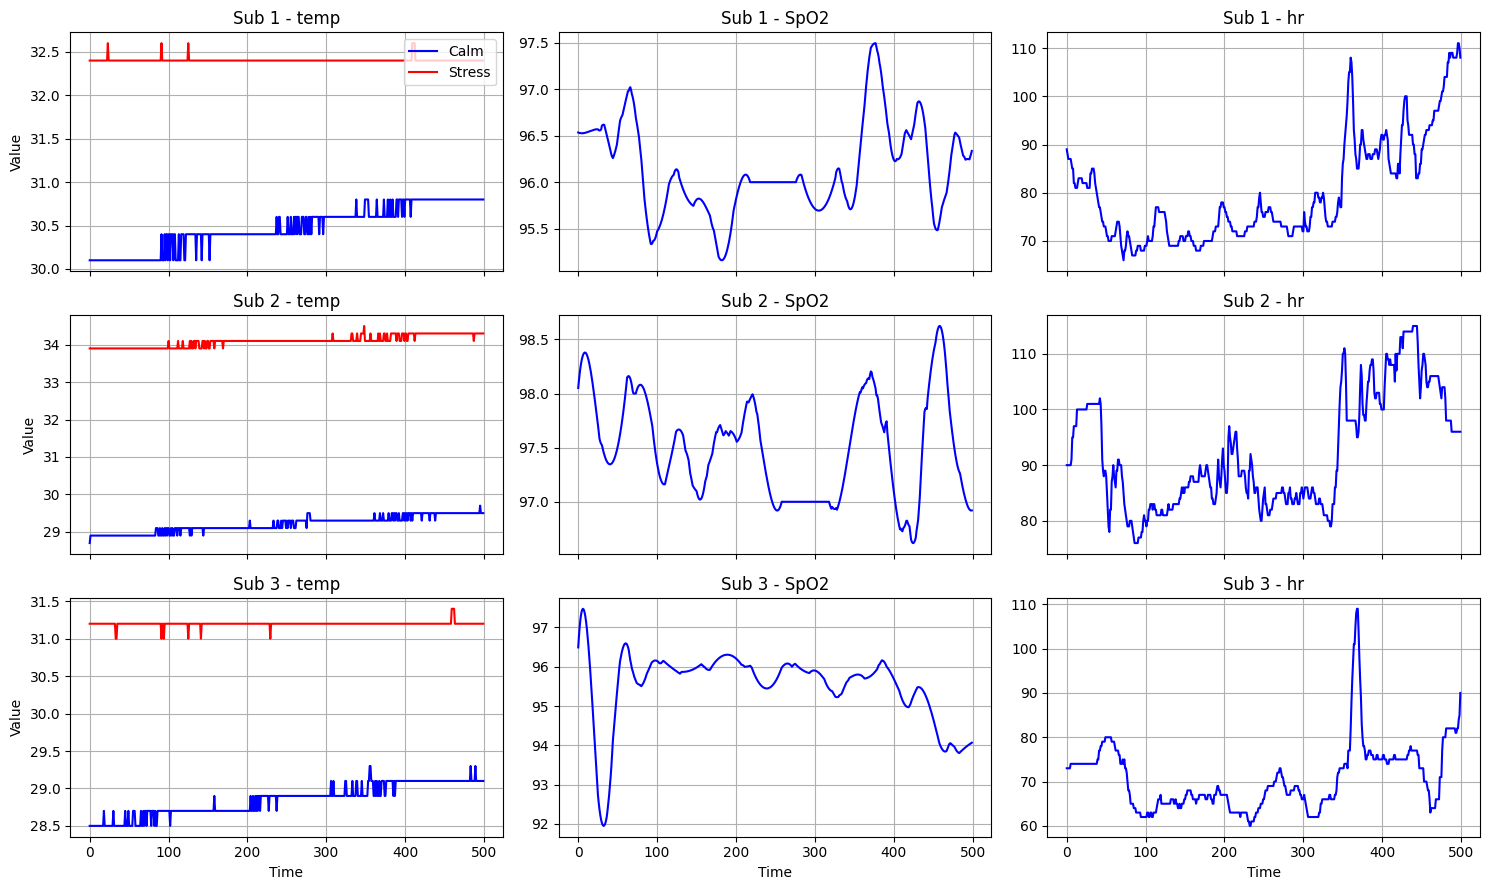

In [73]:
import matplotlib.pyplot as plt
import numpy as np

subject_ids = all_data_df['subject_id'].unique()[0:3]
axes = ['temp', 'SpO2', 'hr']

fig, axs = plt.subplots(len(subject_ids), len(axes), figsize=(15, len(subject_ids)*3), sharex=True)

for i, subject_id in enumerate(subject_ids):
    subject_df = all_data_df[all_data_df['subject_id'] == subject_id]
    calm_sub = subject_df[subject_df['label'] == 'calm']
    stress_sub = subject_df[subject_df['label'] == 'stress']

    for j, axis in enumerate(axes):
        ax = axs[i, j] if len(subject_ids) > 1 else axs[j]
        ax.plot(calm_sub[axis][:500].reset_index(drop=True), label='Calm', color='blue')
        ax.plot(stress_sub[axis][:500].reset_index(drop=True), label='Stress', color='red')
        ax.set_title(f"Sub {subject_id} - {axis}")
        ax.grid(True)

        if i == len(subject_ids)-1:
            ax.set_xlabel("Time")
        if j == 0:
            ax.set_ylabel("Value")

# Add legend to the first subplot only
axs[0, 0].legend(loc='upper right')
plt.tight_layout()
plt.show()


Converted calm and stress into 0 and 1 ( label encoding )


Scaled the X data

In [76]:
le = LabelEncoder()
y_encoded = le.fit_transform(X_df['label'])
X = X_df.drop('label', axis=1)

X = X.fillna(X.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Trained a 1D CNN

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.5947 - loss: 0.6703 - val_accuracy: 0.6438 - val_loss: 0.5704
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7069 - loss: 0.5984 - val_accuracy: 0.8082 - val_loss: 0.5437
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7142 - loss: 0.5720 - val_accuracy: 0.8356 - val_loss: 0.4762
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7783 - loss: 0.4868 - val_accuracy: 0.8219 - val_loss: 0.4487
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7629 - loss: 0.4747 - val_accuracy: 0.8082 - val_loss: 0.4286
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7977 - loss: 0.4504 - val_accuracy: 0.7945 - val_loss: 0.4191
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7580 - loss: 0.4928 - val_accuracy: 0.7945 - val_loss: 0.4108
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7749 - loss: 0.4489 - val_accuracy: 0.8219 - val_loss: 0.

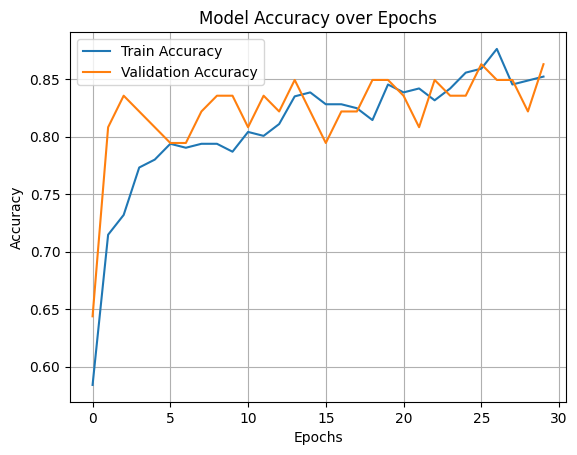

In [77]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt


X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)


model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_train)), activation='softmax')  # Adjust based on # of classes
])



model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_cnn, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test_cnn, y_test)
)


loss, accuracy = model.evaluate(X_test_cnn, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Comparing with other models

In [78]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM (RBF)": SVC(kernel='rbf', probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n Model: {name}")
    print("Accuracy:", acc)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    results[name] = acc


 Model: Random Forest
Accuracy: 0.7808219178082192
Classification Report:
              precision    recall  f1-score   support

        calm       0.81      0.81      0.81        42
      stress       0.74      0.74      0.74        31

    accuracy                           0.78        73
   macro avg       0.78      0.78      0.78        73
weighted avg       0.78      0.78      0.78        73


 Model: SVM (RBF)
Accuracy: 0.8082191780821918
Classification Report:
              precision    recall  f1-score   support

        calm       0.89      0.76      0.82        42
      stress       0.73      0.87      0.79        31

    accuracy                           0.81        73
   macro avg       0.81      0.82      0.81        73
weighted avg       0.82      0.81      0.81        73


 Model: KNN
Accuracy: 0.7808219178082192
Classification Report:
              precision    recall  f1-score   support

        calm       0.84      0.76      0.80        42
      stress       0.71   